# Topic Modelling with Gensim

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words in french

from nltk.corpus import stopwords
stop_words = stopwords.words('french')
stop_words.extend(['plus', 'faire', 'tout'])
print(stop_words)

# spacy stopwords

# spacy_nlp = spacy.load('fr_core_news_md')
# spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
# print(spacy_stopwords)

# combine both lists
#stop_words.extend(spacy_stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront',

In [4]:
# Import Dataset

df = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/LA_TRANSITION_ECOLOGIQUE.csv')
print(df.columns)
df.head()

c:\users\ben.vdb\.conda\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode',
       'Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?',
       'Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?',
       'Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?',
       'Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?',
       'À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?',
       'Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?',
       'Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?',
   

,reference,title,createdAt,publishedAt,updatedAt,trashed,trashedStatus,authorId,authorType,authorZipCode,...,"Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?",Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?,"Par rapport à votre mode de chauffage actuel, pensez-vous qu'il existe des solutions alternatives plus écologiques ?","Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer de mode de chauffage ?","Avez-vous pour vos déplacements quotidiens la possibilité de recourir à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun, le covoiturage, l'auto-partage, le transport à la demande, le vélo, etc. ?","Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?,Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?
0,2-4,transition écologique,2019-01-22 09:37:49,2019-01-22 09:37:49,NaN,False,NaN,VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,97231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enseignement du tri sélectif à l'école,Multiplier les centrales géothermiques
1,2-5,La surpopulation,2019-01-22 09:39:33,2019-01-22 09:39:33,NaN,False,NaN,VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,57000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mettre en oeuvre au niveau national ses engage...,Les problèmes auxquels se trouve confronté l’e...
2,2-6,climat,2019-01-22 09:39:50,2019-01-22 09:39:50,NaN,False,NaN,VXNlcjozZjlhNzAwOS0xYTc2LTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,34140,...,"développer les transports en commun ,",NaN,Non,NaN,Oui,NaN,"Les transports en commun, L'auto partage, Le t...",NaN,NaN,NaN
3,2-7,POLLUTION AIR EAU,2019-01-22 09:40:19,2019-01-22 09:40:19,NaN,False,NaN,VXNlcjozOWQwNzJjNC0xZDEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,17400,...,NaN,Plus de transports publics dans les petites co...,Non,NaN,Non,Le co-voiturage ne correspond pas toujours aux...,Les transports en commun,L'Etat,Elle n'a aucun pouvoir. Impossible de contrain...,NaN
4,2-8,Economie vs Ecologie,2019-01-22 09:41:33,2019-01-22 09:41:33,NaN,False,NaN,VXNlcjo3M2YxN2NlZS0xZDRiLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,35430,...,"Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a...",Oui,une aide significative pour de l'éolien ou du ...,Non,Une piste cyclable pour éviter de risquer ma v...,"Les transports en commun, Le covoiturage, Le vélo","La commune, le département, la région",Demander à Nicolas Hulot,Une vrai politique écologique et non économique


In [5]:
# Convert to list and drop NAs responses
 # 11=reponses a apporter aux problemes

data = df.iloc[:,11].dropna().values.tolist()
 
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", " ", sent) for sent in data]
data = [re.sub("\’", " ", sent) for sent in data]

pprint(data[:10])

['Les problèmes auxquels se trouve confronté l ensemble de la planète et que '
 'dénoncent, dans le plus parfait désordre, les gilets jaunes de France ne '
 'sont-ils pas dus, avant tout, à la surpopulation mondiale ? Cette population '
 'est passée d 1,5 milliards d habitants en 1900 à 7 milliards en 2020 et '
 'montera bientôt à 10 milliards vers 2040. Avec les progrès de la '
 'communication dans ce village mondial, chaque individu, du fin fond de l '
 'Asie au fin fond de l Afrique, en passant par les « quartiers » et les « '
 'campagnes » de notre pays, aspire à vivre – et on ne peu l en blâmer – comme '
 'les moins mal lotis de nos concitoyens (logement, nourriture, biens de '
 'consommation, déplacement,etc.). Voilà la mère de tous les problèmes. Si tel '
 'est bien le cas, la solution à tous les problèmes (stabilisation de la '
 'croissance démographique, partage des richesses, partage des terres, partage '
 'de l eau, protection de la biodiversité, règlement des conflits, lutt

In [9]:
# Tokenisation and cleaning special characters and punctuation

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:10])

[['les', 'problemes', 'auxquels', 'se', 'trouve', 'confronte', 'ensemble', 'de', 'la', 'planete', 'et', 'que', 'denoncent', 'dans', 'le', 'plus', 'parfait', 'desordre', 'les', 'gilets', 'jaunes', 'de', 'france', 'ne', 'sont', 'ils', 'pas', 'dus', 'avant', 'tout', 'la', 'surpopulation', 'mondiale', 'cette', 'population', 'est', 'passee', 'milliards', 'habitants', 'en', 'milliards', 'en', 'et', 'montera', 'bientot', 'milliards', 'vers', 'avec', 'les', 'progres', 'de', 'la', 'communication', 'dans', 'ce', 'village', 'mondial', 'chaque', 'individu', 'du', 'fin', 'fond', 'de', 'asie', 'au', 'fin', 'fond', 'de', 'afrique', 'en', 'passant', 'par', 'les', 'quartiers', 'et', 'les', 'campagnes', 'de', 'notre', 'pays', 'aspire', 'vivre', 'et', 'on', 'ne', 'peu', 'en', 'blamer', 'comme', 'les', 'moins', 'mal', 'lotis', 'de', 'nos', 'concitoyens', 'logement', 'nourriture', 'biens', 'de', 'consommation', 'deplacement', 'etc', 'voila', 'la', 'mere', 'de', 'tous', 'les', 'problemes', 'si', 'tel', 'est

In [11]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=3, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['les', 'problemes', 'auxquels', 'se', 'trouve', 'confronte', 'ensemble', 'de', 'la', 'planete', 'et', 'que', 'denoncent', 'dans', 'le', 'plus', 'parfait', 'desordre', 'les', 'gilets_jaunes', 'de', 'france', 'ne', 'sont', 'ils', 'pas', 'dus', 'avant', 'tout', 'la', 'surpopulation_mondiale', 'cette', 'population', 'est', 'passee', 'milliards_habitants', 'en', 'milliards', 'en', 'et', 'montera', 'bientot', 'milliards', 'vers', 'avec', 'les', 'progres', 'de', 'la', 'communication', 'dans', 'ce', 'village', 'mondial', 'chaque_individu', 'du', 'fin', 'fond', 'de', 'asie', 'au', 'fin', 'fond', 'de', 'afrique', 'en', 'passant', 'par', 'les', 'quartiers', 'et', 'les', 'campagnes', 'de', 'notre', 'pays', 'aspire', 'vivre', 'et', 'on', 'ne', 'peu', 'en', 'blamer', 'comme', 'les', 'moins', 'mal', 'lotis', 'de', 'nos_concitoyens', 'logement', 'nourriture', 'biens', 'de', 'consommation', 'deplacement', 'etc', 'voila', 'la', 'mere', 'de', 'tous', 'les', 'problemes', 'si', 'tel', 'est', 'bien', 'le',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

# nlp = spacy.load('fr', disable=['parser', 'ner'])
nlp = spacy.load('fr_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['probleme', 'confronter', 'ensembl', 'planete', 'denoncent', 'parfaire', 'desordre', 'gilets_jaune', 'france', 'du', 'surpopulation', 'mondial', 'population', 'passe', 'milliard', 'habitant', 'milliard', 'monter', 'bientot', 'milliard', 'progre', 'communication', 'village', 'mondial', 'fond', 'asi', 'fin', 'fond', 'afriqu', 'passer', 'quartier', 'campagne', 'pays', 'aspir', 'vivre', 'peu', 'blamer', 'moins', 'mal', 'lotir', 'concitoyen', 'logement', 'nourriture', 'bien', 'consommation', 'deplacement', 'voila', 'mere', 'tout', 'probleme', 'tel', 'bien', 'cas', 'solution', 'tout', 'probleme', 'stabilisation', 'croissance_demographique', 'partag', 'richesse', 'partag', 'terre', 'partag', 'eau', 'protection', 'biodiversite', 'reglemer', 'conflit', 'deforestation', 'reglemer', 'conflit', 'stabilisation', 'migration', 'concurrence', 'commercial', 'mondial', 'etc', 'francaise', 'europeenne', 'mondial', 'france', 'jouer', 'moteur', 'autour', 'duquel', 'deroulerer', 'grand_debat', 'assez', 'a

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 4), (47, 1), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('afriqu', 1),
  ('anecdotique', 1),
  ('asi', 1),
  ('aspir', 1),
  ('assez', 1),
  ('autour', 1),
  ('bien', 2),
  ('bientot', 1),
  ('biodiversite', 1),
  ('blamer', 1),
  ('campagne', 1),
  ('cas', 1),
  ('commercial', 1),
  ('communication', 1),
  ('concitoyen', 1),
  ('concurrence', 1),
  ('conflit', 2),
  ('confronter', 1),
  ('consommation', 1),
  ('croissance_demographique', 1),
  ('deforestation', 1),
  ('denoncent', 1),
  ('deplacement', 1),
  ('deroulerer', 1),
  ('desordre', 1),
  ('du', 1),
  ('duquel', 1),
  ('eau', 1),
  ('ensembl', 1),
  ('etc', 1),
  ('europeenne', 1),
  ('fin', 1),
  ('fond', 2),
  ('francaise', 1),
  ('france', 2),
  ('gilets_jaune', 1),
  ('grand_debat', 1),
  ('habitant', 1),
  ('jouer', 1),
  ('logement', 1),
  ('lotir', 1),
  ('mal', 1),
  ('mere', 1),
  ('migration', 1),
  ('milliard', 3),
  ('moins', 1),
  ('mondial', 4),
  ('monter', 1),
  ('moteur', 1),
  ('nourriture', 1),
  ('parfaire', 1),
  ('partag', 3),
  ('passe', 1),
  ('passer', 1

In [44]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
lda_model2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5)

lda_model3 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           passes=10)

In [41]:
lda_model4 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           passes=10,
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

NameError: name 'lda_model' is not defined

In [42]:
pprint(lda_model2.print_topics())
pprint(lda_model3.print_topics())
pprint(lda_model4.print_topics())

[(0,
  '0.012*"tout" + 0.006*"moins" + 0.006*"non" + 0.006*"falloir" + '
  '0.005*"mettre" + 0.005*"etat" + 0.005*"produit" + 0.005*"energie" + '
  '0.005*"ecologique" + 0.005*"entreprise"'),
 (1,
  '0.007*"industriel" + 0.006*"transport" + 0.006*"france" + 0.006*"falloir" + '
  '0.006*"mettre" + 0.006*"production" + 0.005*"arreter" + 0.005*"tout" + '
  '0.005*"produit" + 0.005*"consommation"'),
 (2,
  '0.012*"transport" + 0.008*"falloir" + 0.007*"taxer" + 0.006*"developper" + '
  '0.006*"consommation" + 0.006*"entreprise" + 0.005*"produit" + '
  '0.005*"commun" + 0.005*"mettre" + 0.005*"interdire"'),
 (3,
  '0.009*"falloir" + 0.009*"produit" + 0.008*"moins" + 0.006*"taxer" + '
  '0.006*"autre" + 0.005*"favoriser" + 0.005*"interdire" + 0.005*"production" '
  '+ 0.005*"transport" + 0.005*"non"'),
 (4,
  '0.011*"transport" + 0.008*"tout" + 0.007*"mettre" + 0.006*"pollution" + '
  '0.006*"falloir" + 0.006*"developper" + 0.006*"taxer" + 0.006*"voiture" + '
  '0.006*"interdire" + 0.005*"pro

In [24]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.026874990000698

Coherence Score:  0.4509438540168579


In [45]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\ben.vdb\.conda\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.157528 -0.296035       1        1  32.321838
2      0.314068  0.021662       2        1  25.862949
3      0.166796 -0.076779       3        1  15.739128
0     -0.105835  0.320108       4        1  13.305649
1     -0.217501  0.031045       5        1  12.770433, topic_info=     Category         Freq              Term        Total  loglift  logprob
184   Default  7418.000000         transport  7418.000000  30.0000  30.0000
358   Default  5665.000000           produit  5665.000000  29.0000  29.0000
349   Default  3609.000000           voiture  3609.000000  28.0000  28.0000
76    Default  5740.000000           falloir  5740.000000  27.0000  27.0000
486   Default  2969.000000         politique  2969.000000  26.0000  26.0000
197   Default  2783.000000       agriculture  2783.000000  25.0000  25.0000
350   Default  4090.000000         favoriser  4090.000000  24.0000  24.0000
108   Default  2948.000000            commun  2948.000000  23.0000  23.0000
265   Default  3859.000000        production  3859.000000  22.0000  22.0000
79    Default  3850.000000             taxer  3850.000000  21.0000  21.0000
198   Default  2563.000000           arreter  2563.000000  20.0000  20.0000
147   Default  4788.000000            mettre  4788.000000  19.0000  19.0000
404   Default  2575.000000             ville  2575.000000  18.0000  18.0000
258   Default  3487.000000          polluant  3487.000000  17.0000  17.0000
259   Default  3435.000000          produire  3435.000000  16.0000  16.0000
214   Default  2283.000000         pesticide  2283.000000  15.0000  15.0000
55    Default  2228.000000          probleme  2228.000000  14.0000  14.0000
16    Default  3958.000000      consommation  3958.000000  13.0000  13.0000
81    Default  2159.000000           changer  2159.000000  12.0000  12.0000
283   Default  4128.000000         interdire  4128.000000  11.0000  11.0000
24    Default  2041.000000               eau  2041.000000  10.0000  10.0000
86    Default  1989.000000               vie  1989.000000   9.0000   9.0000
780   Default  2018.000000        industriel  2018.000000   8.0000   8.0000
693   Default  2954.000000           energie  2954.000000   7.0000   7.0000
84    Default  1907.000000              mode  1907.000000   6.0000   6.0000
355   Default  2684.000000             local  2684.000000   5.0000   5.0000
419   Default  2639.000000           limiter  2639.000000   4.0000   4.0000
523   Default  3088.000000        developper  3088.000000   3.0000   3.0000
315   Default  2590.000000               bio  2590.000000   2.0000   2.0000
260   Default  2588.000000            reduir  2588.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
299    Topic5  1048.432129        croissance  1049.269775   2.0572  -4.5583
54     Topic5  1011.296509        population  1012.135437   2.0572  -4.5944
552    Topic5  1009.577271         ressource  1010.417053   2.0572  -4.5961
1513   Topic5   984.990601              agir   985.829041   2.0572  -4.6207
446    Topic5   959.954102         economiqu   960.792236   2.0572  -4.6465
1110   Topic5   917.121887        changement   917.963928   2.0571  -4.6921
1111   Topic5   862.492065         chauffage   863.337585   2.0571  -4.7536
365    Topic5   756.185730      comportement   757.022888   2.0569  -4.8851
1888   Topic5   745.769470            planet   746.606506   2.0569  -4.8990
297    Topic5   737.223938            argent   738.065979   2.0569  -4.9105
53     Topic5   698.390198           planete   699.227783   2.0568  -4.9646
731    Topic5   684.763550         ameliorer   685.618408   2.0568  -4.9843
1621   Topic5   660.888977        conscience   661.725769   2.0568  -5.0198
918    Topic5   643.988525          question   644.829285   2.0567  -5.0457
972    Topic5   632.516968         education   633.356750   2.0567  -5.0637
411    

In [43]:
# optimize over the number of topics (coherence calculation)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)


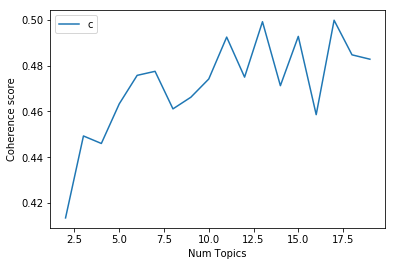

In [44]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4135
Num Topics = 3  has Coherence Value of 0.4493
Num Topics = 4  has Coherence Value of 0.446
Num Topics = 5  has Coherence Value of 0.4633
Num Topics = 6  has Coherence Value of 0.4757
Num Topics = 7  has Coherence Value of 0.4775
Num Topics = 8  has Coherence Value of 0.4611
Num Topics = 9  has Coherence Value of 0.4662
Num Topics = 10  has Coherence Value of 0.4741
Num Topics = 11  has Coherence Value of 0.4924
Num Topics = 12  has Coherence Value of 0.475
Num Topics = 13  has Coherence Value of 0.4991
Num Topics = 14  has Coherence Value of 0.4712
Num Topics = 15  has Coherence Value of 0.4927
Num Topics = 16  has Coherence Value of 0.4586
Num Topics = 17  has Coherence Value of 0.4998
Num Topics = 18  has Coherence Value of 0.4847
Num Topics = 19  has Coherence Value of 0.4828


In [47]:
# Visualize the topics for 7

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[5], corpus, id2word)
vis

c:\users\ben.vdb\.conda\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.044319 -0.020453       1        1  18.295979
3     -0.142688  0.013590       2        1  17.832438
0      0.106491 -0.092352       3        1  15.887640
4      0.014229 -0.103221       4        1  14.917718
2      0.020487  0.169140       5        1  13.331877
5     -0.144553 -0.029631       6        1  12.329134
1      0.101714  0.062928       7        1   7.405210, topic_info=     Category         Freq           Term        Total  loglift  logprob
204   Default  6575.000000      transport  6575.000000  30.0000  30.0000
86    Default  3958.000000          taxer  3958.000000  29.0000  29.0000
236   Default  2040.000000      pesticide  2040.000000  28.0000  28.0000
310   Default  3763.000000      interdire  3763.000000  27.0000  27.0000
118   Default  2731.000000         commun  2731.000000  26.0000  26.0000
389   Default  5134.000000        produit  5134.000000  25.0000  25.0000
344   Default  2136.000000            bio  2136.000000  24.0000  24.0000
217   Default  2219.000000    agriculture  2219.000000  23.0000  23.0000
380   Default  3579.000000        voiture  3579.000000  22.0000  22.0000
218   Default  2626.000000        arreter  2626.000000  21.0000  21.0000
705   Default  3080.000000        energie  3080.000000  20.0000  20.0000
438   Default  2236.000000          ville  2236.000000  19.0000  19.0000
416   Default  1150.000000         animal  1150.000000  18.0000  18.0000
216   Default  1309.000000    agriculteur  1309.000000  17.0000  17.0000
284   Default  3049.000000       polluant  3049.000000  16.0000  16.0000
559   Default  3564.000000     developper  3564.000000  15.0000  15.0000
382   Default  3472.000000      favoriser  3472.000000  14.0000  14.0000
744   Default  1763.000000       vehicule  1763.000000  13.0000  13.0000
45    Default  4614.000000          moins  4614.000000  12.0000  12.0000
952   Default  1345.000000       nucleair  1345.000000  11.0000  11.0000
270   Default  1155.000000         camion  1155.000000  10.0000  10.0000
292   Default  3593.000000     production  3593.000000   9.0000   9.0000
54    Default  2685.000000           pays  2685.000000   8.0000   8.0000
308   Default  1379.000000      emballage  1379.000000   7.0000   7.0000
363   Default  2987.000000  environnement  2987.000000   6.0000   6.0000
39    Default   922.000000       logement   922.000000   5.0000   5.0000
861   Default   766.000000           velo   766.000000   4.0000   4.0000
687   Default  1321.000000         nature  1321.000000   3.0000   3.0000
723   Default  1310.000000      carburant  1310.000000   2.0000   2.0000
203   Default  1058.000000          train  1058.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
76     Topic7    57.411957       nettoyer   107.618286   1.9746  -6.9992
1023   Topic7   308.932129            air  1244.880371   1.2093  -5.3163
801    Topic7   144.375824    disparition   421.981659   1.5304  -6.0770
2070   Topic7    56.532238          peine   110.956383   1.9287  -7.0146
45     Topic7   730.853577          moins  4614.482910   0.7602  -4.4552
606    Topic7   232.815598    responsable   892.125427   1.2596  -5.5992
58     Topic7   368.348419       probleme  1990.883057   0.9157  -5.1404
745    Topic7   143.864716          viand   487.496002   1.3826  -6.0805
292    Topic7   502.290863     production  3593.098877   0.6354  -4.8302
316    Topic7   451.404663      pollution  3375.494141   0.5911  -4.9371
746    Topic7   147.983154          foret   563.568481   1.2658  -6.0523
71     Topic7   175.539917          vivre   790.064392   1.0987  -5.8816
158    Topic7   455.338470         mettre  4462.074219   0.3207  -4.9284
107    Topic7   410.767029          autre  3717.697021   0.4002  -5.0314
452    Topic7   331.440002        limiter  2710.406738   0.5016  -5.2460
357    Topic7   285.402222           don

In [50]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.011*"pays" + 0.011*"falloir" + 0.010*"tout" + 0.009*"environnement" + '
  '0.008*"mettre" + 0.008*"politique" + 0.007*"entreprise" + 0.006*"etat" + '
  '0.006*"action" + 0.006*"citoyen" + 0.006*"france" + 0.006*"mondial" + '
  '0.006*"probleme" + 0.005*"ecologique" + 0.005*"faire" + 0.005*"grand" + '
  '0.004*"niveau" + 0.004*"place" + 0.004*"devoir" + 0.004*"agir"'),
 (1,
  '0.013*"arreter" + 0.012*"moins" + 0.011*"animal" + 0.008*"production" + '
  '0.007*"mettre" + 0.007*"pollution" + 0.007*"autre" + 0.006*"nature" + '
  '0.006*"probleme" + 0.006*"falloir" + 0.005*"limiter" + 0.005*"terre" + '
  '0.005*"elevage" + 0.005*"air" + 0.005*"donc" + 0.004*"agriculture" + '
  '0.004*"aussi" + 0.004*"fin" + 0.004*"favoriser" + 0.004*"humain"'),
 (2,
  '0.021*"interdire" + 0.017*"produit" + 0.017*"pesticide" + 0.015*"bio" + '
  '0.014*"agriculture" + 0.010*"agriculteur" + 0.009*"favoriser" + '
  '0.008*"tout" + 0.007*"eau" + 0.007*"utilisation" + 0.007*"environnement" + '
  '0.006*"

In [55]:
# find dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model2, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

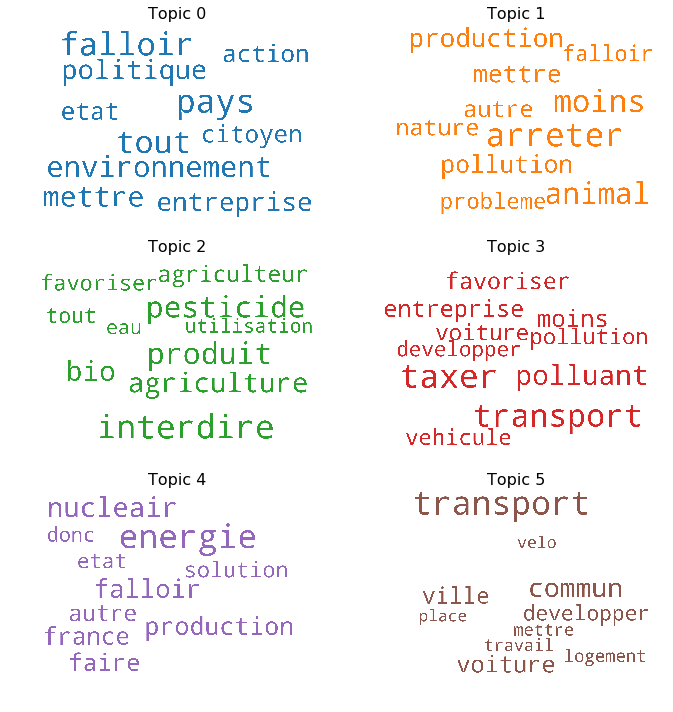

In [69]:
# 1. Wordcloud of Top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [67]:
c[1]

([(0, 0.017920911),
  (1, 0.01796553),
  (2, 0.8924155),
  (3, 0.017929513),
  (4, 0.017908003),
  (5, 0.017942682),
  (6, 0.01791789)],
 [(73, [2]), (74, [2]), (75, [2]), (76, [2]), (77, [2]), (78, [2]), (79, [2])],
 [(73, [(2, 0.9994267)]),
  (74, [(2, 0.9994795)]),
  (75, [(2, 0.99956477)]),
  (76, [(2, 0.9985179)]),
  (77, [(2, 0.9993387)]),
  (78, [(2, 0.99899834)]),
  (79, [(2, 0.9986909)])])

In [32]:
# HDP model
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word, T=5)

In [38]:
topic_info = hdp.print_topics(num_topics=5, num_words=10)
pprint(topic_info)

[(0,
  '0.005*transport + 0.005*falloir + 0.005*tout + 0.004*produit + 0.004*moins '
  '+ 0.004*mettre + 0.003*entreprise + 0.003*autre + 0.003*taxer + 0.003*non'),
 (1,
  '0.001*transport + 0.001*tout + 0.001*falloir + 0.001*produit + 0.001*taxer '
  '+ 0.001*moins + 0.001*entreprise + 0.001*interdire + 0.001*mettre + '
  '0.001*developper'),
 (2,
  '0.001*transport + 0.001*produit + 0.001*tout + 0.001*taxer + 0.001*falloir '
  '+ 0.001*moins + 0.001*interdire + 0.001*entreprise + 0.001*consommation + '
  '0.001*pollution'),
 (3,
  '0.001*transport + 0.001*tout + 0.001*taxer + 0.001*produit + 0.001*falloir '
  '+ 0.001*interdire + 0.001*pollution + 0.001*moins + 0.001*mettre + '
  '0.001*developper'),
 (4,
  '0.001*transport + 0.001*tout + 0.001*non + 0.001*taxer + 0.001*moins + '
  '0.001*produit + 0.001*falloir + 0.001*interdire + 0.001*mettre + '
  '0.001*limiter')]


In [16]:
# LDA Mallet algo

mallet_path = 'C:/Users/ben.vdb/.conda/envs/NLP/Lib/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ben.vdb\\AppData\\Local\\Temp\\546cec_state.mallet.gz'

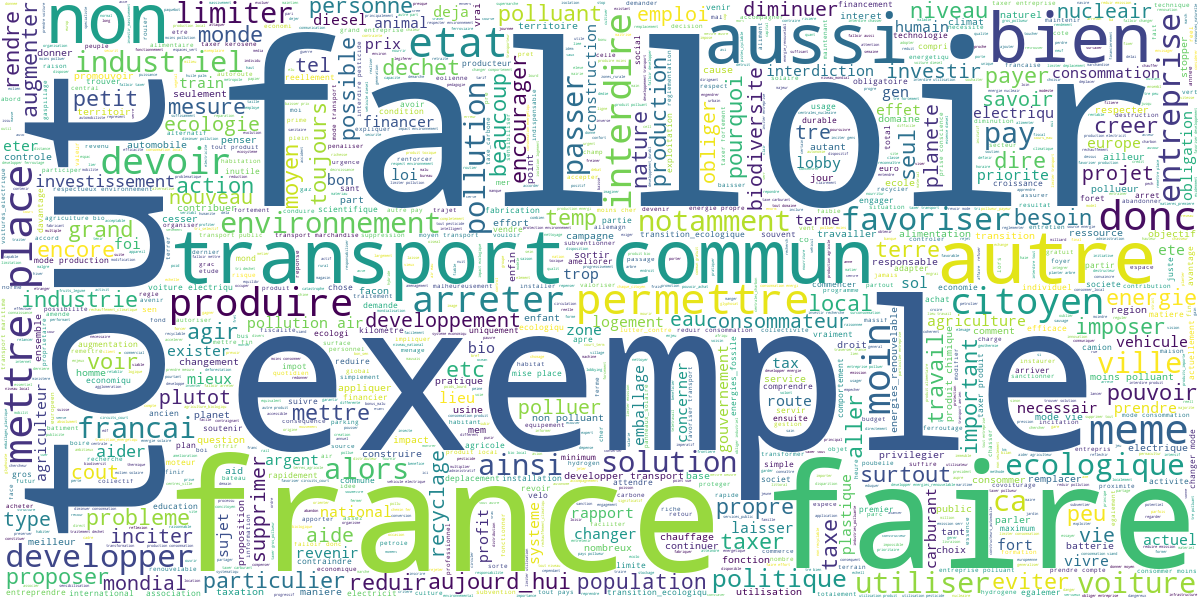

In [49]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed text together.
long_string = ','.join([",".join(sentence) for sentence in data_lemmatized])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1200, height=600)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [48]:
# dominant topic of each comment

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


TypeError: '<' not supported between instances of 'int' and 'tuple'